## 🌐 Connect Colab to Google Drive

In [ ]:
from google.colab import drive

drive.mount('/gdrive')
%cd /gdrive/My Drive/Colab Notebooks/Homework 1_lst

Mounted at /gdrive
/gdrive/My Drive/Colab Notebooks/Homework 1_lst


## ⚙️ Import Libraries

In [ ]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

!pip install keras-cv
import keras_cv

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import requests
from io import BytesIO
import cv2
from PIL import Image
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)

%matplotlib inline

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 32.2 MB/s eta 0:00:00
2.17.1


## ⏳ Load the Data

In [ ]:
data = np.load('training_set.npz')
X = data['images']
y = data['labels']
print(X.shape, y.shape)
print(type(X))

(13759, 96, 96, 3) (13759, 1)
<class 'numpy.ndarray'>


In [ ]:
mask = np.array([i < 11959 for i in range(X.shape[0])])
X = X[mask]
y = y[mask]
print(X.shape, y.shape)

(11959, 96, 96, 3) (11959, 1)


## ⛏ Splitting the Data

In [ ]:
# One-hot encoding
y = tfk.utils.to_categorical(y, len(np.unique(y)))

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y,
                  random_state = seed, test_size = 0.15,
                  stratify = np.argmax(y,axis=1))

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val,
                  random_state=seed, test_size=len(X_test),
                  stratify=np.argmax(y_train_val,axis=1))

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (8371, 96, 96, 3), y_train shape: (8371, 8)
X_val shape: (1794, 96, 96, 3), y_val shape: (1794, 8)
X_test shape: (1794, 96, 96, 3), y_test shape: (1794, 8)


## 👍 RandAugment for final fine tuning

In [ ]:
from tqdm import tqdm

# Custom augmentation layer for each transformation
class CustomAugmentationLayer(tf.keras.layers.Layer):
    def __init__(self, transformation):
        super(CustomAugmentationLayer, self).__init__()
        self.transformation = transformation

    def call(self, inputs):
        return self.transformation(inputs)

# Function to apply a single transformation to a random portion of X_train
def augment_with_transformation(X, y, transformation, portion=40, batch_size=128):
    # Sample a random quarter of the data
    indices = np.random.choice(len(X), len(X) // portion, replace=False)
    X_subset = tf.gather(X, indices)
    y_subset = tf.gather(y, indices)

    # Apply transformation in batches and store results
    augmented_batches = []
    num_batches = (len(X_subset) + batch_size - 1) // batch_size
    for i in tqdm(range(0, len(X_subset), batch_size), desc="Applying Transformation", total=num_batches):
        batch = X_subset[i:i + batch_size]
        augmented_batch = CustomAugmentationLayer(transformation)(batch)
        augmented_batches.append(augmented_batch)

    X_augmented = tf.concat(augmented_batches, axis=0)
    y_augmented = tf.gather(y, indices)

    X = tf.concat([X, X_augmented], axis=0)
    y = tf.concat([y, y_augmented], axis=0)
    return X, y

rand_augment = [keras_cv.layers.RandAugment(value_range=[0, 255], augmentations_per_image=1,
                                           magnitude = 0.8),
                keras_cv.layers.RandAugment(value_range=[0, 255], augmentations_per_image=1,
                                           magnitude = 0.8)]
X_train_augmented = X_train
y_train_augmented = y_train
del X_train
del y_train
for transformation in rand_augment:
  X_train_augmented, y_train_augmented = augment_with_transformation(
       X_train_augmented, y_train_augmented, transformation = transformation,
       portion = 1, batch_size=128
  )

X_train_augmented = tf.cast(X_train_augmented, tf.uint8)
print(X_train_augmented.shape)
print(y_train_augmented.shape)

In [ ]:
np.savez("training_augmented_big_randaugment.npz", X_train=X_train_augmented, y_train=y_train_augmented)
del X_train_augmented
del y_train_augmented

In [ ]:
np.load("training_augmented_big_randaugment.npz")["X_train"].shape

(33484, 96, 96, 3)

## ‼ Plot examples

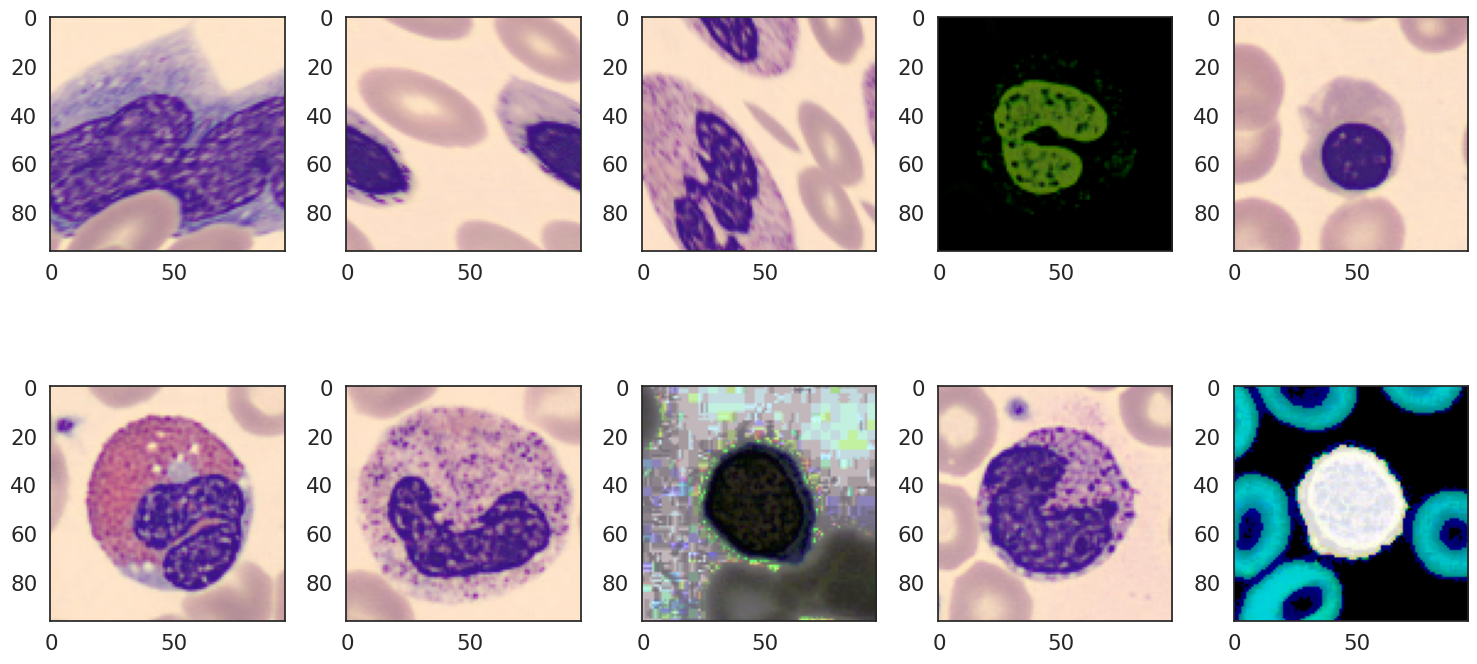

In [ ]:
X_train = np.load("training_augmented_big_randaugment.npz")["X_train"]

# Set the number of samples to plot
num_samples = 10

# Select 10 random indices
random_indices = np.random.choice(X_train.shape[0], num_samples, replace=False)

# Create a figure for the plots
plt.figure(figsize=(15, 8))

# Plot the 10 random samples
for i, idx in enumerate(random_indices):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_train[idx, :, :, :])

plt.tight_layout()
plt.show()